In [34]:
import xarray as xr
import pandas as pd
import locale

# locale.setlocale(locale.LC_ALL,'en_US')
# locale.setlocale(locale.LC_ALL,'en_US')
dataset = xr.open_dataset('MiningProcess_Flotation_Plant_Database.h5', engine = 'h5netcdf')
df = dataset.to_pandas()


In [35]:
## Resampling
df = df.resample('1h').mean()

# # ##
# df.iloc[:-1, df.columns.get_loc('% Iron Feed')] = df['% Iron Feed'].iloc[1:].values
# df.iloc[:-1, df.columns.get_loc('% Silica Feed')] = df['% Silica Feed'].iloc[1:].values
# df.iloc[:-1, df.columns.get_loc('% Iron Concentrate')] = df['% Iron Concentrate'].iloc[1:].values
# df.iloc[:-1, df.columns.get_loc('% Silica Concentrate')] = df['% Silica Concentrate'].iloc[1:].values

# df = df.iloc[:-1]

## Split into input and output
X = df.iloc[:,:-2]
Y = df['% Silica Concentrate']

In [36]:
# Adding lagged variables

import numpy as np
X_copy = X.copy()
lagged_variables = {}
for lag in range(1,7):
    lagged_variable = np.zeros(len(X_copy))
    lagged_variable[lag:] = Y.iloc[:-lag]

    lagged_variables[f'% Silica Concentrate Lag {lag}'] = lagged_variable
    # X.loc[:,] = lagged_variable


for variable in X_copy.columns:
    X_variable = X_copy[variable]
    for lag in range(1,7):
        lagged_variable = np.zeros(len(X_variable))
        lagged_variable[lag:] = X_variable.iloc[:-lag]


        # X.loc[f'{variable} Lag {lag}'] = lagged_variable
        lagged_variables[f'{variable} Lag {lag}'] = lagged_variable

df_lagged_variables = pd.DataFrame(lagged_variables,index=X_copy.index)

X = X.join(df_lagged_variables)
X = X[5:]

In [37]:
remove_variables = True
N = 22
if remove_variables:
    variables = pd.read_csv('variables.csv')
    X = X.loc[:,variables['Column'].iloc[:N]]


In [38]:
# Split to calibration-validation set and test set
X_cal = X['20170615':'20170723']
Y_cal = Y['20170615':'20170723']
X_test = X['20170424':'20170506']
Y_test = Y['20170424':'20170506']

count    935.000000
mean      -0.000471
std        0.763491
min       -3.440000
25%       -0.210000
50%        0.000000
75%        0.190000
max        3.610000
Name: % Silica Concentrate, dtype: float64

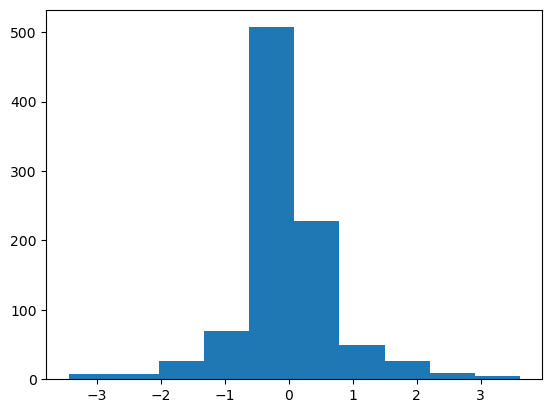

In [39]:
import matplotlib.pyplot as plt
plt.hist(Y_cal.diff())

Y_cal.diff().describe()

In [40]:
# Remove missing values in between
# X_cal.loc['201707060400':'201707062200'] = pd.NA
# X_cal.dropna(inplace=True)

# Y_cal.loc['201707060400':'201707062200'] = pd.NA
# Y_cal.dropna(inplace=True)

# X_test.loc['20170421':'20170424'] = pd.NA
# X_test.dropna(inplace=True)

# Y_test.loc['20170421':'20170424'] = pd.NA
# Y_test.dropna(inplace=True)

C:\Users\antto\AppData\Local\Temp\ipykernel_10688\695225842.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.dropna(inplace=True)


In [41]:
# Store data

with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split_variables_removed.h5') as store:
    store.put('X_cal', X_cal)
    store.put('Y_cal', Y_cal)
    store.put('X_test', X_test)
    store.put('Y_test', Y_test)